# Introduction

This notebook contains data prep for the next two notebooks.

## About the data

There are three levels of frequency:
- Daily fact table
- ARY dimensions, financial report figures *as-reported yearly* in 10-K annual reports.
- ART dimensions, financial report figures *as-reported trailing twelve months*. These aggregate the latest four 10-Q filings in a running fashion and thus are updated more frequently than ARY.

For each ART row there are many daily rows and exactly five ARY rows, representing the 10-K filings prior to that quarterly release. I will aggregate the ARY rows, join them to ART rows, then broadcast the join to the daily rows.

## Features
Without handling inflation, making companies from 1998 comparable to those in 2023 is impossible. We would also like to compare companies at different scale. Financial ratios help since metrics like profit margin mean the same thing across time. However, in order to guess a company's market cap well, an ML algorithm needs to have some indication of the company's size. After all, you generally wouldn't expect a company with miniscule assets, profits and cashflows to have a massive market cap. Thus I also [min-max scale](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)) the currency figures, grouped by date.

Steps: 
- Exclude target-derived variables -- anything related to `marketcap`
- Choose a major figure from each financial statement as ratio denominator, namely `assets`, `fcf` and `revenue`.
- Use remaining currency figures as numerators and compute all of ratios for TTM and 5-year average
- Capture change with (TTM - 5Y) for each ratio
- Min-max scale currency figures to the unit interval, grouped by date.

## Target
A tree ensemble algorithm computes errors internally and uses those to learn. Being off by 50% for a small company would produce a much smaller error than being off by 50% for an ultra cap. That would tend to make the algorithm "care" more about large-cap stocks. I want all stocks to have a similar priority, so I'll be min-max scaling `marketcap`, followed by some nonlinear transforms to spread out the marketcap distribution.

Steps:
- Min-max scale
- Then shift away from 0 and take the log

---

Disclaimer: I am not an investment professional. None of my work within or related to this notebook should be considered investment advice. It is not.

# Setup

In [30]:
import duckdb
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('dark_background')

data_path = Path(os.getenv('DATA_HOME'))
duckdb_path = data_path.joinpath('analytics_demo/sharadar.duckdb')

In [2]:
%%time
con = duckdb.connect(str(duckdb_path))
df_daily_targ = con.execute('from fct_daily_targ where mcap_daily > 0').fetch_df()
df_fin_art_currency = con.execute('from dim_fin_art_currency').fetch_df()
df_fin_ary5y_currency = con.execute('from dim_fin_ary5y_currency').fetch_df()
con.close()

print('df_daily_targ:', df_daily_targ.shape)
display(df_daily_targ.head(2))
print('df_fin_art_currency:', df_fin_art_currency.shape)
display(df_fin_art_currency.head(2))
print('df_fin_ary5y_currency:', df_fin_ary5y_currency.shape)
display(df_fin_ary5y_currency.head(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

df_daily_targ: (1764497, 14)


,key_daily,ticker,date,volume,closeadj,mcap_daily,ev_daily,price_chg_1y,excess_price_chg_1y,key_dim_fin,mcap_rank,mcap_perc_rank,mcap_rank_rev,mcap_perc_rank_rev
0,TRTN_2017-07-06,TRTN,2017-07-06,290500.0,24.00,2.467400e+09,8.759100e+09,0.058250,-0.043324,TRTN_ART_2017-03-31_2017-05-15,1510,0.291763,3664,0.708237
1,UST1_1999-01-06,UST1,1999-01-06,404200.0,19.72,6.392400e+09,6.371300e+09,-0.130532,-0.180562,UST1_ART_1998-09-30_1998-11-10,357,0.049986,6767,0.950014


df_fin_art_currency: (634776, 73)


,key_dim_fin,accoci,assets,assetsavg,assetsc,assetsnc,capex,cashneq,cashnequsd,cor,...,revenue,revenueusd,rnd,sbcomp,sgna,tangibles,taxassets,taxexp,taxliabilities,workingcapital
0,CCTG_ART_2022-03-31_2023-03-22,-617288.0,16390029.0,NaN,15478272.0,911757.0,-177639.0,5285940.0,5285940.0,19694031.0,...,27169935.0,27169935.0,829024.0,0.0,4184951.0,16273120.0,100338.0,399828.0,257246.0,8697363.0
1,CCTG_ART_2022-09-30_2023-07-28,-1713691.0,18841982.0,NaN,16147238.0,2694744.0,NaN,5901314.0,5901314.0,NaN,...,NaN,NaN,NaN,NaN,NaN,18745138.0,88108.0,NaN,399547.0,10306443.0


df_fin_ary5y_currency: (1904105, 73)


,key_dim_fin,accoci,assets,assetsavg,assetsc,assetsnc,capex,cashneq,cashnequsd,cor,...,revenue,revenueusd,rnd,sbcomp,sgna,tangibles,taxassets,taxexp,taxliabilities,workingcapital
0,TBACQ_ART_2006-12-31_2007-02-14,-1706000.0,133437000.0,137182500.0,97829000.0,35608000.0,-2716000.0,6506000.0,6506000.0,133706000.0,...,205769000.0,205769000.0,0.0,0.0,53516000.0,115567000.0,0.0,4010000.0,0.0,78217000.0
1,TBACQ_ART_2006-12-31_2007-02-14,-1196000.0,146530000.0,143287000.0,113649000.0,32881000.0,-2444000.0,3814000.0,3814000.0,146399000.0,...,224487000.0,224487000.0,0.0,0.0,58450000.0,129989000.0,4757000.0,4922000.0,1776000.0,89131000.0


CPU times: user 5.35 s, sys: 3.02 s, total: 8.37 s
Wall time: 9.4 s


# Feature engineering

In [43]:
set_currency_cols = set(df_fin_art_currency.columns.drop(['key_dim_fin', 'marketcap', 'ev']))
list_currency_cols = sorted(list(set_currency_cols))
set_currency_cols_denom = set(['assetsavg', 'fcf', 'revenue'])
set_currency_cols_num = set_currency_cols.difference(set_currency_cols_denom)

# For now, just pitch rows with NULL demoniators
for c in set_currency_cols_denom:
    df_fin_art_currency = df_fin_art_currency[~df_fin_art_currency[c].isnull()].copy()
    df_fin_ary5y_currency = df_fin_ary5y_currency[~df_fin_ary5y_currency[c].isnull()].copy()

# Create ratios within TTM and 5-year tables
df_art_cur_ratios = {'key_dim_fin': df_fin_art_currency.key_dim_fin}
df_ary5y_cur_ratios = {'key_dim_fin': df_fin_ary5y_currency.key_dim_fin}
df_ary5y_cur_ratio_std = {'key_dim_fin': df_fin_ary5y_currency.key_dim_fin}

art_ratio_colnames = []
ary5y_ratio_colnames = []

for a in set_currency_cols_num:
    for b in set_currency_cols_denom:
        c = a + '_over_' + b + '_art'
        art_ratio_colnames.append(c)
        df_art_cur_ratios[c] = df_fin_art_currency[a] / df_fin_art_currency[b]

        d = a + '_over_' + b + '_ary5y_avg'
        ary5y_ratio_colnames.append(d)
        df_ary5y_cur_ratios[d] = df_fin_ary5y_currency[a] / df_fin_ary5y_currency[b]

        e = a + '_over_' + b + '_ary5y_std'
        df_ary5y_cur_ratio_std[e] = df_fin_ary5y_currency[a] / df_fin_ary5y_currency[b]
        
df_art_cur_ratios = pd.DataFrame(df_art_cur_ratios)
df_ary5y_cur_ratios = pd.DataFrame(df_ary5y_cur_ratios).groupby('key_dim_fin').mean().reset_index()
df_ary5y_cur_ratio_std = pd.DataFrame(df_ary5y_cur_ratio_std).groupby('key_dim_fin').std().reset_index()
df_ratio_features = df_art_cur_ratios.merge(df_ary5y_cur_ratios, how='inner', on='key_dim_fin')
df_ratio_features = df_ratio_features.merge(df_ary5y_cur_ratio_std, how='inner', on='key_dim_fin')

# Capture changes between TTM and 5-year features
df_feat_change = {'key_dim_fin': df_ratio_features.key_dim_fin}
for a, b in zip(art_ratio_colnames, ary5y_ratio_colnames):
    df_feat_change[a + '_minus_' + b] = df_ratio_features[a] - df_ratio_features[b]
df_feat_change = pd.DataFrame(df_feat_change)
df_ratio_features = df_ratio_features.merge(df_feat_change, how='inner', on='key_dim_fin')

print(df_ratio_features.shape)
display(df_ratio_features.head(2))

(375894, 805)


,key_dim_fin,ppnenet_over_assetsavg_art,ppnenet_over_revenue_art,ppnenet_over_fcf_art,consolinc_over_assetsavg_art,consolinc_over_revenue_art,consolinc_over_fcf_art,retearn_over_assetsavg_art,retearn_over_revenue_art,retearn_over_fcf_art,...,liabilitiesc_over_fcf_art_chg,payables_over_assetsavg_art_chg,payables_over_revenue_art_chg,payables_over_fcf_art_chg,ncfx_over_assetsavg_art_chg,ncfx_over_revenue_art_chg,ncfx_over_fcf_art_chg,deferredrev_over_assetsavg_art_chg,deferredrev_over_revenue_art_chg,deferredrev_over_fcf_art_chg
0,BPTSY_ART_2023-12-31_2024-04-08,0.018558,inf,-0.024059,-1.003093,-inf,1.300390,-1.141957,-inf,1.480409,...,0.236173,0.02981,NaN,0.058686,-0.000509,NaN,0.000788,0.0,NaN,-0.0
1,AABC_ART_2001-12-31_2002-03-07,0.025659,0.616008,2.363787,0.008218,0.19729,0.757055,0.021120,0.507058,1.945718,...,NaN,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [9]:
# Min-max scale TTM currency figures by day.
df_daily_cur = df_daily_targ[['key_daily', 'date', 'key_dim_fin']].copy()
df_daily_cur = df_daily_cur.merge(df_fin_art_currency[['key_dim_fin'] + list_currency_cols], how='inner', on='key_dim_fin')
df_daily_cur = df_daily_cur.drop(columns='key_dim_fin')

df_mins = df_daily_cur.drop(columns='key_daily').groupby('date').min()
df_maxes = df_daily_cur.drop(columns='key_daily').groupby('date').max()
df_spans = (df_maxes - df_mins).copy()
df_mins.columns = [x + '_min' for x in df_mins.columns]
df_spans.columns = [x + '_span' for x in df_spans.columns]
df_mins = df_mins.reset_index()
df_spans = df_spans.reset_index()
df_daily_cur = df_daily_cur.merge(df_mins, how='inner', on='date').merge(df_spans, how='inner', on='date')

df_daily_cur_scaled = {'key_daily': df_daily_cur.key_daily}
for c in list_currency_cols:
    df_daily_cur_scaled[c + '_art_scaled'] = ((df_daily_cur[c] - df_daily_cur[c + '_min']) / df_daily_cur[c + '_span'])
df_daily_cur_scaled = pd.DataFrame(df_daily_cur_scaled)

print(df_daily_cur_scaled.shape)
df_daily_cur_scaled.head(2)

(1622992, 71)


,key_daily,accoci_art_scaled,assets_art_scaled,assetsavg_art_scaled,assetsc_art_scaled,assetsnc_art_scaled,capex_art_scaled,cashneq_art_scaled,cashnequsd_art_scaled,consolinc_art_scaled,...,revenue_art_scaled,revenueusd_art_scaled,rnd_art_scaled,sbcomp_art_scaled,sgna_art_scaled,tangibles_art_scaled,taxassets_art_scaled,taxexp_art_scaled,taxliabilities_art_scaled,workingcapital_art_scaled
0,JPM1_2000-01-05,0.947437,0.013720,0.014674,NaN,NaN,0.998895,2.266093e-03,0.053153,0.005587,...,0.000926,0.050761,0.004727,0.142055,0.003936,0.014949,0.000000,0.001582,0.000103,NaN
1,CTLG_1999-05-05,0.845462,0.000003,0.000003,0.000002,0.000003,0.995180,3.999578e-07,0.000012,0.012208,...,0.000077,0.003763,0.000175,0.043849,0.000023,0.000002,0.000037,0.003962,0.000002,0.002837


# Target Engineering

<Axes: >

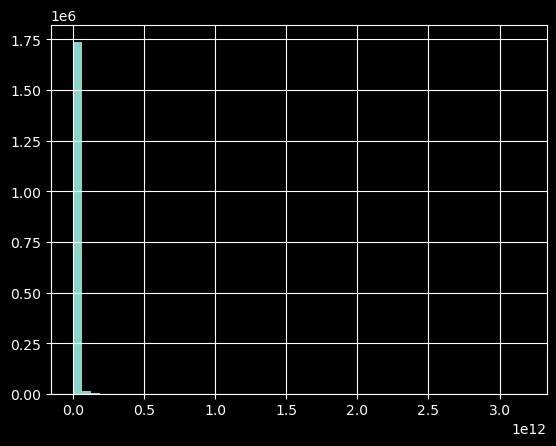

In [10]:
df_daily_targ.mcap_daily.hist(bins=50)

array([[<Axes: title={'center': 'mcap_daily'}>,
        <Axes: title={'center': 'mcap_daily_scaled_log'}>]], dtype=object)

(1764497, 4)


,key_daily,key_dim_fin,date,mcap_daily_scaled_log
0,TRTN_2017-07-06,TRTN_ART_2017-03-31_2017-05-15,2017-07-06,12.711554
1,UST1_1999-01-06,UST1_ART_1998-09-30_1998-11-10,1999-01-06,14.343115


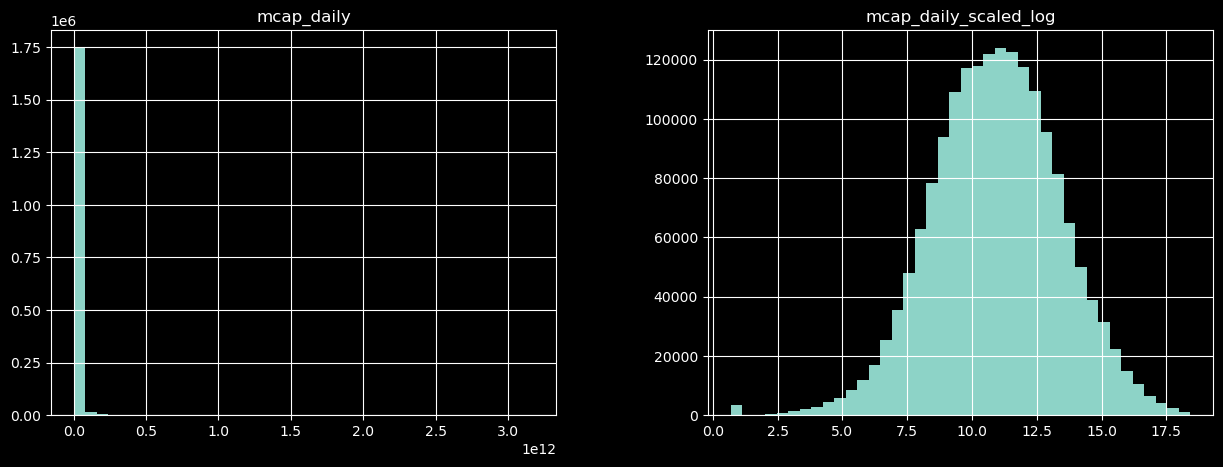

In [11]:
df_mcap_rescale = df_daily_targ.loc[~df_daily_targ.mcap_daily.isnull(), ['key_daily', 'key_dim_fin', 'date', 'mcap_daily']].copy()
mins = df_mcap_rescale[['date', 'mcap_daily']].groupby('date').min()
maxes = df_mcap_rescale[['date', 'mcap_daily']].groupby('date').max()
spans = (maxes - mins).copy()
mins = mins.reset_index().rename(columns={'mcap_daily': 'mcap_daily_min'})
spans = spans.reset_index().rename(columns={'mcap_daily': 'mcap_daily_span'})
df_mcap_rescale = df_mcap_rescale.merge(mins, how='inner', on='date').merge(spans, how='inner', on='date')
df_mcap_rescale['mcap_daily_scaled'] = (df_mcap_rescale.mcap_daily - df_mcap_rescale.mcap_daily_min) / df_mcap_rescale.mcap_daily_span
df_mcap_rescale['mcap_daily_scaled_log'] = (1e8*df_mcap_rescale['mcap_daily_scaled'] + 2).apply(np.log)
display(df_mcap_rescale[['mcap_daily', 'mcap_daily_scaled_log']].hist(bins=40, figsize=(15, 5)))

df_mcap_rescale = df_mcap_rescale[['key_daily', 'key_dim_fin', 'date', 'mcap_daily_scaled_log']]

print(df_mcap_rescale.shape)
display(df_mcap_rescale.head(2))

Much better. Errors on larger market caps still will be larger, but there are far more small cap stocks, which should balance things out.

# Merge and export

Store regression target/feature table back in duckdb file.

In [12]:
df_reg = df_mcap_rescale.merge(df_daily_cur_scaled, how='inner', on='key_daily')
df_reg = df_reg.merge(df_ratio_features, how='inner', on='key_dim_fin').drop(columns='key_dim_fin')
print(df_reg.shape)
df_reg.head()

(1131433, 877)


,key_daily,date,mcap_daily_scaled_log,accoci_art_scaled,assets_art_scaled,assetsavg_art_scaled,assetsc_art_scaled,assetsnc_art_scaled,capex_art_scaled,cashneq_art_scaled,...,liabilitiesc_over_fcf_art_chg,payables_over_assetsavg_art_chg,payables_over_revenue_art_chg,payables_over_fcf_art_chg,ncfx_over_assetsavg_art_chg,ncfx_over_revenue_art_chg,ncfx_over_fcf_art_chg,deferredrev_over_assetsavg_art_chg,deferredrev_over_revenue_art_chg,deferredrev_over_fcf_art_chg
0,CLGRF_2015-03-04,2015-03-04,9.202882,0.209219,5.332554e-07,6.245411e-07,1.175933e-06,1.017986e-06,0.998723,0.000000e+00,...,-1.545088,0.006677,0.015955,-0.083869,0.000000,0.000000,-0.000000,-0.008832,-0.039161,0.147835
1,WKSP_2020-11-04,2020-11-04,5.968387,0.082440,1.343325e-09,1.285366e-09,1.268050e-08,1.149845e-09,0.999808,2.687597e-10,...,1.158344,0.597255,0.356970,0.398766,0.030528,0.029801,-0.072859,0.000000,0.000000,-0.000000
2,TRVI_2023-04-05,2023-04-05,8.340353,0.058691,1.850337e-07,1.422991e-07,1.586698e-06,1.769279e-09,0.999334,1.146325e-07,...,-0.140707,-0.012327,NaN,-0.016355,0.000000,NaN,-0.000000,0.000000,NaN,-0.000000
3,NEGG_2014-12-03,2014-12-03,7.801168,0.309514,1.421071e-07,1.347147e-07,1.158509e-06,7.198741e-08,0.998589,1.241008e-07,...,1.241618,0.003231,0.011130,-0.028533,-0.012591,-0.020680,0.127142,0.000000,0.000000,-0.000000
4,SBFM_2016-01-06,2016-01-06,6.103200,0.128194,4.431116e-10,4.907181e-10,3.984254e-09,0.000000e+00,0.999148,3.021857e-09,...,-0.407429,0.100989,-inf,-0.018180,0.000000,NaN,-0.000000,0.000000,NaN,-0.000000


In [13]:
# reduce size
list_cols_feat = df_reg.columns.drop(['key_daily', 'date']).tolist()
df_reg[list_cols_feat] = df_reg[list_cols_feat].astype(np.float32)

In [14]:
con = duckdb.connect(str(duckdb_path))
con.sql("CREATE OR REPLACE TABLE mcap_reg AS SELECT * FROM df_reg")
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))